In [1]:
pip install -e .

Obtaining file:///home/natalie/nsalab/Users/naw1/desk2/dl/gym-child
  Attempting uninstall: gym-maze
    Found existing installation: gym-maze 0.4
    Uninstalling gym-maze-0.4:
      Successfully uninstalled gym-maze-0.4
  Running setup.py develop for gym-maze
Note: you may need to restart the kernel to use updated packages.


# Q Learning Training Environment

In [1]:
import gym
#import gym_child
import gym_teen
import numpy as np
import time
import sys
import math
import random
import matplotlib.pyplot as plt

In [2]:
def get_explore_rate(t,min_explore_rate,decay_fact):
    return max(min_explore_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))


def get_learning_rate(t,min_learning_rate,decay_fact):
    return max(min_learning_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))

In [3]:
# variables: 
neps = 100
tstep = 200
min_explore_rate = 0.001
min_learning_rate = 0.2
#grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
#decay_fact = np.prod(grid_size, dtype=float) / 10.0
decay_fact = np.prod((9,9),dtype=float)/10.0
#state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
explore_rate = get_explore_rate(0,min_explore_rate,decay_fact)
learning_rate = get_learning_rate(0,min_learning_rate,decay_fact)

max_t = np.prod((9,9),dtype=int)*100
streak_to_end = 100
solved_t = np.prod((9,9),dtype=int)

In [4]:
def select_action(env,state, q_table,explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action
    


In [5]:
def state_to_bucket(state,env):
    grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
    state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= state_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_bounds[i][1]:
            bucket_index = grid_size[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = state_bounds[i][1] - state_bounds[i][0]
            offset = (grid_size[i]-1)*state_bounds[i][0]/bound_width
            scaling = (grid_size[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)



In [6]:
def run_qlearn(env,q_table, explore_rate, learning_rate, neps=200,tstep=100):
    env.render()
    num_streaks = 0
    discount_factor = 0.99
    max_t = np.prod((9,9),dtype=int)*100
    streak_to_end = 100
    solved_t = np.prod((9,9),dtype=int)
    decay_fact = np.prod((9,9),dtype=float)/10.0
    num_steps = []
    episode_reward = []
    
    for ep in range(neps):
        if ep == 0:
            time.sleep(5)
        obv = env.reset()
        print('------------'+str(ep))
        state_0 = state_to_bucket(obv,env)
        total_reward = 0.0

        
        for t in range(tstep):
            # select best action and execute
            action = select_action(env,state_0, q_table, explore_rate)
            obv,reward,done,_ = env.step(action)
            
            # update the state you are in, add reward (observe result)
            state = state_to_bucket(obv,env)
            total_reward += reward
            #print('cur' + str(reward))
            #print(total_reward)
            #print(reward, total_reward)
            
            # update Q-table
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
            
            # update state
            state_0 = state
            
            env.render()
            time.sleep(0.1)

            # update parameters
            #explore_rate = get_explore_rate(ep,min_explore_rate,decay_fact)
            #learning_rate = get_learning_rate(ep,min_learning_rate,decay_fact)
            
            if done:
                episode_reward.append(total_reward)
                num_steps.append(t+1)

                
                plt.imshow(env.render())
                plt.show()

                time.sleep(1)
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (ep, t, total_reward, num_streaks))

                if t <= solved_t:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= max_t - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (ep, t, total_reward))

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > streak_to_end:
            break
            
        explore_rate = get_explore_rate(ep,0.001,decay_fact)
        learning_rate = get_learning_rate(ep,0.2,decay_fact)
                
    return q_table, num_steps, episode_reward

In [7]:
def train_qlearn(env,q_table, explore_rate, learning_rate, neps=100,tstep=100):
    env.render()
    num_streaks = 0
    discount_factor = 0.99
    max_t = np.prod((9,9),dtype=int)*100
    streak_to_end = 100
    solved_t = np.prod((9,9),dtype=int)
    decay_fact = np.prod((9,9),dtype=float)/10.0
    num_steps = []
    episode_reward = []
    
    for ep in range(neps):
        if ep == 0:
            time.sleep(5)
        obv = env.reset()
        print('------------'+str(ep))
        state_0 = state_to_bucket(obv,env)
        total_reward = 0.0

        
        for t in range(tstep):
            # select best action and execute
            action = select_action(env,state_0, q_table, explore_rate)
            obv,reward,done,_ = env.step(action)
            
            # update the state you are in, add reward (observe result)
            state = state_to_bucket(obv,env)
            total_reward += reward

            # update state
            state_0 = state
            
            env.render()
            time.sleep(0.1)
            
            if done:
                episode_reward.append(total_reward)
                num_steps.append(t+1)

                
                plt.imshow(env.render())
                plt.show()

                time.sleep(1)
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (ep, t, total_reward, num_streaks))

                if t <= solved_t:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= max_t - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (ep, t, total_reward))

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > streak_to_end:
            break
            
        explore_rate = get_explore_rate(ep,0.001,decay_fact)
        learning_rate = get_learning_rate(ep,0.2,decay_fact)
                
    return q_table, num_steps, episode_reward

pygame 2.1.2 (SDL 2.0.18, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
set the target x to 162
set the target y to 136
------------0
(161, 133)
current distance is: 13.038404810405298, and future distance is 3.1622776601683795
the stepsize has decreased and is now 5


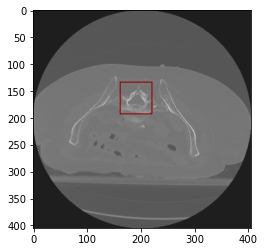

Episode 0 finished after 291.000000 time steps with total reward = 10.000000 (streak 0).
------------1
(158, 141)
current distance is: 14.866068747318506, and future distance is 6.4031242374328485
the stepsize has decreased and is now 5


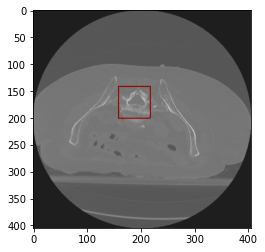

Episode 1 finished after 60.000000 time steps with total reward = 17.000000 (streak 0).
------------2
(166, 127)
current distance is: 16.64331697709324, and future distance is 9.848857801796104


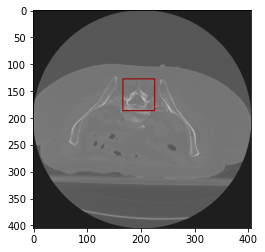

Episode 2 finished after 591.000000 time steps with total reward = 10.000000 (streak 1).
------------3
(168, 134)
current distance is: 13.416407864998739, and future distance is 6.324555320336759
the stepsize has decreased and is now 5


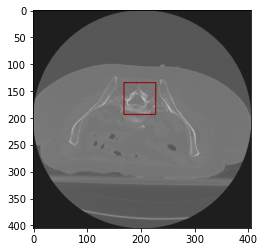

Episode 3 finished after 675.000000 time steps with total reward = 21.000000 (streak 0).
------------4
(165, 141)
current distance is: 15.297058540778355, and future distance is 5.830951894845301
the stepsize has decreased and is now 5


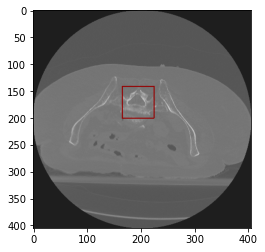

Episode 4 finished after 571.000000 time steps with total reward = -10.000000 (streak 0).
------------5
(169, 135)
current distance is: 17.029386365926403, and future distance is 7.0710678118654755
the stepsize has decreased and is now 5


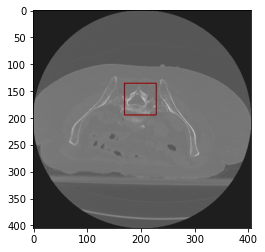

Episode 5 finished after 604.000000 time steps with total reward = 22.000000 (streak 0).
------------6
(170, 131)
current distance is: 17.0, and future distance is 9.433981132056603


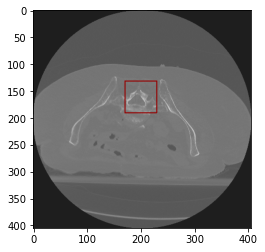

Episode 6 finished after 55.000000 time steps with total reward = 8.000000 (streak 0).
------------7
(163, 137)
current distance is: 11.045361017187261, and future distance is 1.4142135623730951
the stepsize has decreased and is now 5


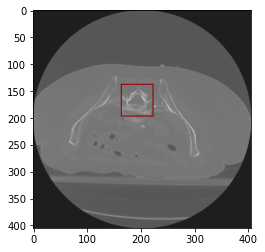

Episode 7 finished after 259.000000 time steps with total reward = 24.000000 (streak 1).
------------8
(167, 136)
current distance is: 15.0, and future distance is 5.0
the stepsize has decreased and is now 5


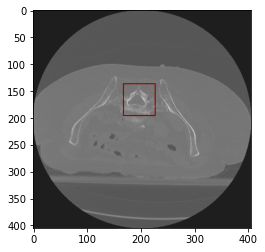

Episode 8 finished after 93.000000 time steps with total reward = 17.000000 (streak 0).
------------9
(163, 144)
current distance is: 13.601470508735444, and future distance is 8.06225774829855


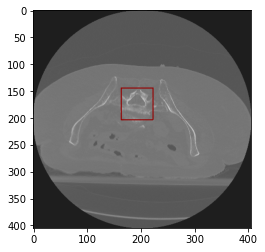

Episode 9 finished after 37.000000 time steps with total reward = 16.000000 (streak 0).
------------10
(169, 140)
current distance is: 15.652475842498529, and future distance is 8.06225774829855


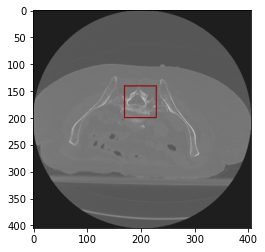

Episode 10 finished after 27.000000 time steps with total reward = 4.000000 (streak 1).
------------11
(154, 131)
current distance is: 17.0, and future distance is 9.433981132056603


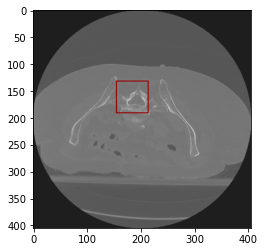

Episode 11 finished after 380.000000 time steps with total reward = 18.000000 (streak 2).
------------12
(166, 133)
current distance is: 14.317821063276353, and future distance is 5.0
the stepsize has decreased and is now 5


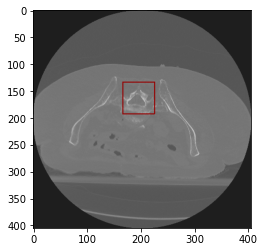

Episode 12 finished after 285.000000 time steps with total reward = 10.000000 (streak 0).
------------13
(169, 135)
current distance is: 17.029386365926403, and future distance is 7.0710678118654755
the stepsize has decreased and is now 5


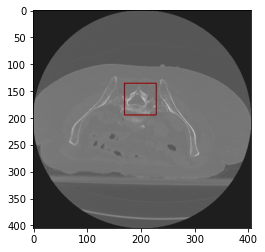

Episode 13 finished after 22.000000 time steps with total reward = 3.000000 (streak 0).
------------14
(153, 134)
current distance is: 12.041594578792296, and future distance is 9.219544457292887


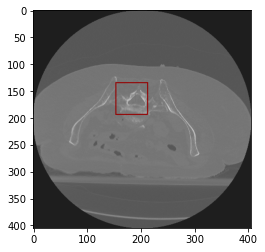

Episode 14 finished after 71.000000 time steps with total reward = 20.000000 (streak 1).
------------15
(157, 135)
current distance is: 12.083045973594572, and future distance is 5.0990195135927845
the stepsize has decreased and is now 5


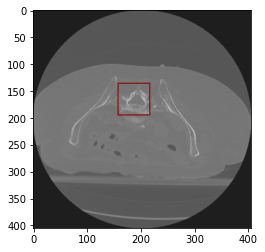

Episode 15 finished after 340.000000 time steps with total reward = 9.000000 (streak 2).
------------16
(171, 132)
current distance is: 19.4164878389476, and future distance is 9.848857801796104


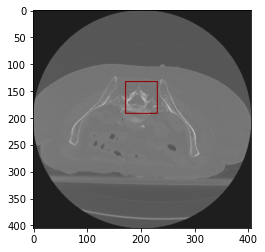

Episode 16 finished after 37.000000 time steps with total reward = 16.000000 (streak 0).
------------17
(154, 142)
current distance is: 18.973665961010276, and future distance is 10.0


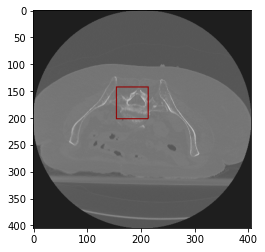

Episode 17 finished after 167.000000 time steps with total reward = 8.000000 (streak 1).
------------18
(171, 135)
current distance is: 14.212670403551895, and future distance is 9.055385138137417


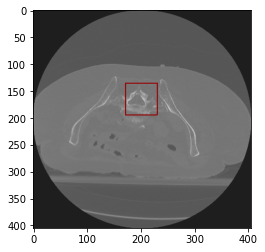

Episode 18 finished after 292.000000 time steps with total reward = 6.000000 (streak 0).
------------19
(159, 136)
current distance is: 10.44030650891055, and future distance is 3.0
the stepsize has decreased and is now 5


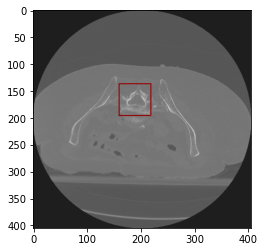

Episode 19 finished after 203.000000 time steps with total reward = 21.000000 (streak 0).
------------20
(166, 130)
current distance is: 16.492422502470642, and future distance is 7.211102550927978
the stepsize has decreased and is now 5


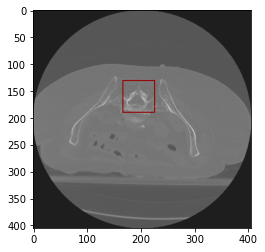

Episode 20 finished after 90.000000 time steps with total reward = 11.000000 (streak 0).
------------21
(163, 131)
current distance is: 12.083045973594572, and future distance is 5.0990195135927845
the stepsize has decreased and is now 5


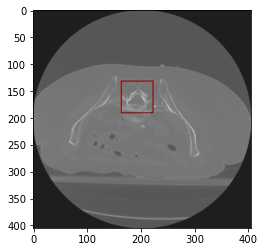

Episode 21 finished after 176.000000 time steps with total reward = 8.000000 (streak 0).
------------22
(160, 127)
current distance is: 19.1049731745428, and future distance is 9.219544457292887
the stepsize has decreased and is now 5


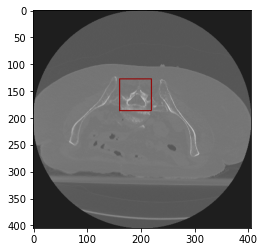

Episode 22 finished after 219.000000 time steps with total reward = 23.000000 (streak 0).
------------23
(160, 131)
current distance is: 15.132745950421556, and future distance is 5.385164807134504
the stepsize has decreased and is now 5


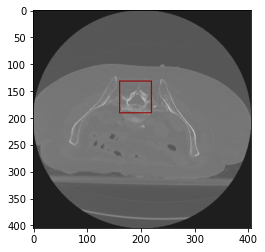

Episode 23 finished after 77.000000 time steps with total reward = 4.000000 (streak 0).
------------24
(152, 136)
current distance is: 20.0, and future distance is 10.0
the stepsize has decreased and is now 5


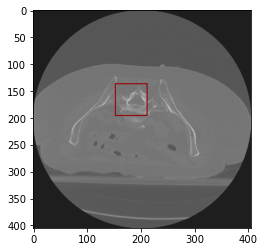

Episode 24 finished after 70.000000 time steps with total reward = 7.000000 (streak 1).
------------25
(155, 132)
current distance is: 15.652475842498529, and future distance is 8.06225774829855


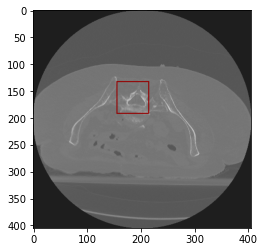

Episode 25 finished after 130.000000 time steps with total reward = 2.000000 (streak 2).
------------26
(157, 131)
current distance is: 15.811388300841896, and future distance is 7.0710678118654755
the stepsize has decreased and is now 5


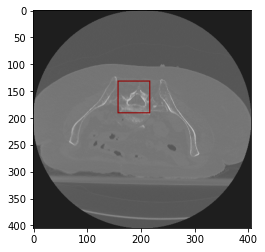

Episode 26 finished after 181.000000 time steps with total reward = 3.000000 (streak 0).
------------27
(161, 127)
current distance is: 19.026297590440446, and future distance is 9.055385138137417
the stepsize has decreased and is now 5


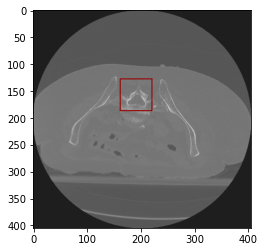

Episode 27 finished after 70.000000 time steps with total reward = 5.000000 (streak 0).
------------28
(167, 130)
current distance is: 16.76305461424021, and future distance is 7.810249675906654
the stepsize has decreased and is now 5


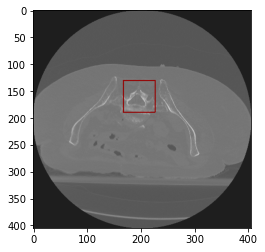

Episode 28 finished after 349.000000 time steps with total reward = 7.000000 (streak 1).
------------29
(166, 134)
current distance is: 12.649110640673518, and future distance is 4.47213595499958
the stepsize has decreased and is now 5


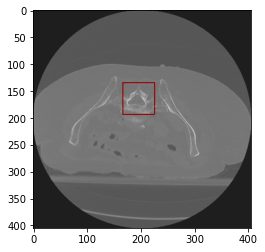

Episode 29 finished after 147.000000 time steps with total reward = 19.000000 (streak 0).
------------30
(158, 134)
current distance is: 12.649110640673518, and future distance is 4.47213595499958
the stepsize has decreased and is now 5


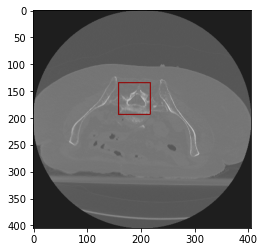

Episode 30 finished after 40.000000 time steps with total reward = 13.000000 (streak 0).
------------31
(171, 140)
current distance is: 19.4164878389476, and future distance is 9.848857801796104


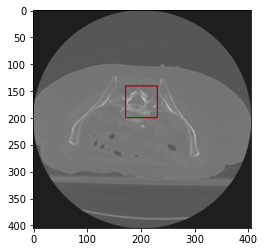

Episode 31 finished after 168.000000 time steps with total reward = 26.000000 (streak 1).
------------32
(161, 136)
current distance is: 9.0, and future distance is 1.0
the stepsize has decreased and is now 5


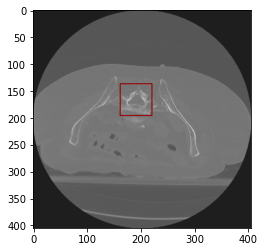

Episode 32 finished after 0.000000 time steps with total reward = 1.000000 (streak 0).
------------33
(156, 136)
current distance is: 16.0, and future distance is 6.0
the stepsize has decreased and is now 5


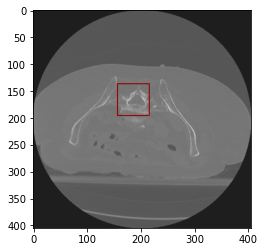

Episode 33 finished after 161.000000 time steps with total reward = 8.000000 (streak 1).
------------34
(157, 132)
current distance is: 15.524174696260024, and future distance is 6.4031242374328485
the stepsize has decreased and is now 5


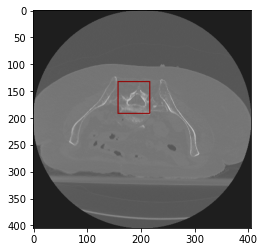

Episode 34 finished after 69.000000 time steps with total reward = 14.000000 (streak 0).
------------35
(168, 144)
current distance is: 18.973665961010276, and future distance is 10.0


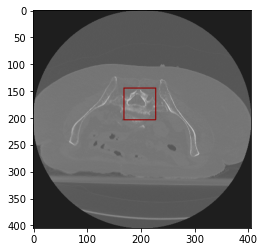

Episode 35 finished after 12.000000 time steps with total reward = 13.000000 (streak 1).
------------36
(167, 136)
current distance is: 15.0, and future distance is 5.0
the stepsize has decreased and is now 5


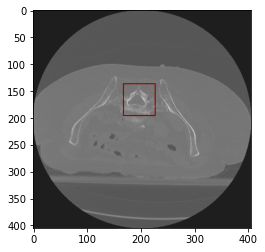

Episode 36 finished after 169.000000 time steps with total reward = 19.000000 (streak 2).
------------37
(152, 133)
We STOPPED USING THE OSCILLATION: current distance is: 20.223748416156685, and future distance is 10.44030650891055


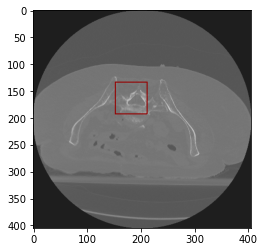

Episode 37 finished after 128.000000 time steps with total reward = 7.000000 (streak 0).
------------38
(163, 131)
current distance is: 15.033296378372908, and future distance is 5.0990195135927845
the stepsize has decreased and is now 5


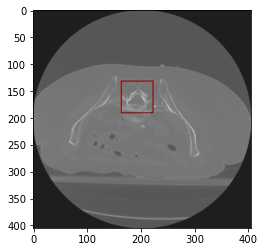

Episode 38 finished after 32.000000 time steps with total reward = 12.000000 (streak 0).
------------39
(151, 139)
We STOPPED USING THE OSCILLATION: current distance is: 21.213203435596427, and future distance is 11.40175425099138


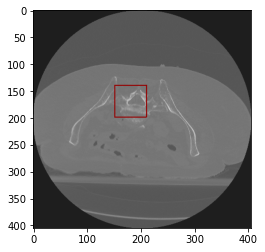

Episode 39 finished after 85.000000 time steps with total reward = 18.000000 (streak 1).
Testing
------------0
(156, 146)
We STOPPED USING THE OSCILLATION: current distance is: 20.8806130178211, and future distance is 11.661903789690601


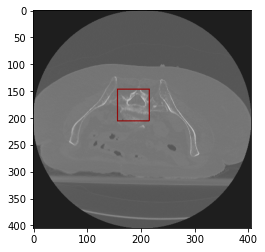

Episode 0 finished after 15.000000 time steps with total reward = 6.000000 (streak 0).
------------1
Episode 1 timed out at 8099 with total reward = -39.000000.
------------2


In [8]:
# Run Training 

# This is for no grid gray scale. 
#    def __init__(self, maze_file = None, width=None,height=None,target_x = None, target_y = None)
#env_qlearn = gym.make('maze-v0',height=60,width=60, target_x = 135, target_y = 180)
env = gym.make('maze-v0',height=60,width=60)
env.set_target_xy(x = 162, y = 136)
environment_type = "grayscale"
#Make Q table
q_table0 = np.zeros((405,405) + (4,), dtype=float)

# still uses a 9x9 grid. 
#env_qlearn = gym.make('maze-v0')
#Make Q Table 
#q_table0 = np.zeros((9,9) + (4,), dtype=float)


fin_q_table, train_num_steps, train_episode_reward  = run_qlearn(env,q_table0,explore_rate,learning_rate,neps=100,tstep=max_t)

print('Testing')
fin_q_table, test_num_steps, test_episode_reward = train_qlearn(env,fin_q_table, explore_rate, learning_rate, neps=100,tstep=max_t)
print('Complete')
env.render()
env.close()


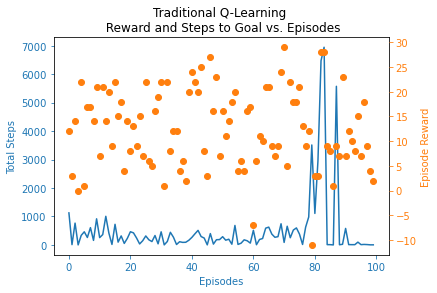

In [ ]:
import matplotlib.pyplot as plt
# length = len(fit.history['nb_episode_steps'])
length = len(train_num_steps)
fig = plt.figure()
ax = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)
ax.plot(range(length), train_num_steps, color="C0")
ax.set_xlabel("Episodes", color="C0")
ax.set_ylabel("Total Steps", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")
ax2.scatter(range(length), train_episode_reward, color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Episode Reward', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")
ax.set_title("Traditional Q-Learning Training \n Reward and Steps to Goal vs. Episodes")
fig.savefig(f"Thresholded_Traditional_Q_learn_training_{length}eps_1_{environment_type}")

In [ ]:
length = len(test_num_steps)
fig = plt.figure()
ax = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)
ax.plot(range(length), test_num_steps, color="C0")
ax.set_xlabel("Episodes", color="C0")
ax.set_ylabel("Total Steps", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")
ax2.scatter(range(length), test_episode_reward, color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Episode Reward', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")
ax.set_title("Traditional Q-Learning Testing \n Reward and Steps to Goal vs. Episodes")
fig.savefig(f"Thresholded_Traditional_Q_learn_testing_{length}eps_1_{environment_type}")

In [ ]:
fin_q_table.shape

(405, 405, 4)

In [2]:
sum(train_num_steps)/len(train_num_steps)
print(f"This is the average for all 100 testing episodes {sum(test_num_steps)/len(test_num_steps)}")
print(f"This is the average for all 100 testing episodes {sum(test_num_steps[::50])/len(test_num_steps[::50])}")


NameError: name 'train_num_steps' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
#### ACTION = ["N", "S", "E", "W"]

<AxesSubplot:>

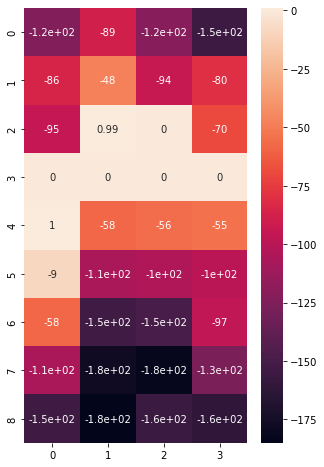

In [ ]:
fig,ax = plt.subplots(figsize=(5,8))
sns.heatmap(fin_q_table[4,:,:],annot=True)